In [12]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import random
import os
from datetime import datetime
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer as Imputer
from sklearn.metrics import confusion_matrix,accuracy_score,precision_recall_fscore_support
import keras
from keras.models import Model, Sequential
from keras.layers import Dense
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
import eli5
import joblib
from eli5.sklearn import PermutationImportance
from utils import *

In [6]:
training_set_path = 'Training.csv'
test_set_path = 'Testing.csv'

training_df = pd.read_csv(training_set_path)
test_df = pd.read_csv(test_set_path)

In [7]:
label_d = {}

def datetime_to_timestamp(dt):
    try:
        return datetime.strptime(dt, '%m/%d/%Y %H:%M').weekday()
    except:
        return datetime.strptime(dt, '%Y-%m-%d %H:%M:%S').weekday()
    
def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df = df.dropna()
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    return df[indices_to_keep].astype(np.float64)

def train_test_dataset(df_train, df_test, deep=True):
    labelencoder = LabelEncoder()

    X_train = df_train.drop(columns=['Label']).copy()
    y_train = df_train.iloc[:, -1].values.reshape(-1,1).copy()
    y_train = np.ravel(y_train).copy()
    if deep:
        y_train = to_categorical(y_train)
    
    if df_test is not None:
        X_test = df_test.drop(columns=['Label']) .copy()
        y_test = df_test.iloc[:, -1].values.reshape(-1,1).copy()
        y_test = np.ravel(y_test).copy()
        if deep:
            y_test = to_categorical(y_test)

        return  X_train, X_test, y_train, y_test
    
    else:
        return train_test_split(X_train, y_train)
    
def show_cm(cm):
    f,ax=plt.subplots(figsize=(5,5))
    sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
    plt.xlabel("y_pred")
    plt.ylabel("y_true")
    plt.show()

def from_categorical(y_):
    return np.array([np.argmax(i) for i in y_])

def discretize(a):
    return 1 if a > 0.5 else 0

def labels_to_numbers(df: pd.DataFrame, name='Label'):
    labels = df[name].unique()
    d = {label: idx for idx, label in enumerate(labels)}

    return d

def number_to_label(df, number, name='Label'):
    labels = df[name].unique()
    d = {idx: label for idx, label in enumerate(labels)}
    return d[number]
        

def prepare_df(df: pd.DataFrame, dropcols=None, scaler=None, ldict=None):
    temp_df = df.copy()
    if dropcols:
        temp_df = temp_df.drop(columns=dropcols)
    if not ldict:
        ltn_dict = labels_to_numbers(temp_df)
    else:
        ltn_dict = ldict
    temp_df['Label'] = temp_df['Label'].map(ltn_dict)
        
    temp_df = clean_dataset(temp_df)
    if scaler == 'minmax':
        scaler = joblib.load('models/scaler.pkl')
        # scaler = MinMaxScaler()
    elif scaler == 'standard':
        scaler = joblib.load('models/standard_scaler.pkl')
        # scaler = StandardScaler()
        
    if scaler:
        temp_df[temp_df.columns[:-1]] = scaler.fit_transform(temp_df[temp_df.columns[:-1]])
        # joblib.dump(scaler, 'models/standard_scaler.pkl')
    
    return temp_df

def binarize_label(y, label):
    idx = y == label
    
    y[idx] = 1
    y[~idx] = 0
    
def evaluate_model(model, df, binarize=None):
    X = df.drop(columns=['Label']).copy()
    y = df.iloc[:, -1].values.reshape(-1,1).copy()
    y = np.ravel(y).copy()
    if binarize is not None:
        binarize_label(y, binarize)
    
    model.evaluate(X, y)
    
    y_predicted = model.predict(X)
    cm = confusion_matrix(y, vdiscretize(y_predicted))
    show_cm(cm)
    
def unsup_compare_results(model, X, y_true):
    y_pred = model.predict(X)
    return f1_score(y_true, y_pred, average=None)

def plot_cm(model, X, y_true):
    y_pred = model.predict(X)
    cm = confusion_matrix(y_true, y_pred)
    show_cm(cm)
    
def make_binary_svm(train, test, l):
    _X_train, _X_test, _y_train, _y_test = train_test_dataset(train, test, deep=False)
    binarize_label(_y_train, l)
    binarize_label(_y_test, l)
    # _y_train[_y_train == 0] = -1
    # _y_train[_y_train == 0] = -1
    return _X_train, _X_test, _y_train, _y_test

def check_all_labels(train, test, model_constructor, l_name='Label', constructor_kwargs=None):
    labels = train[l_name].unique()
    for label in labels:
        print(f'============= Label {number_to_label(clean_test, label)} ==================')
        X_train, X_test, y_train, y_test = make_binary_svm(clean_train, clean_test, label)
        if constructor_kwargs:
            model = model_constructor(**constructor_kwargs)
        else:
            model = model_constructor()
        model.fit(X_train, y_train)
        print(unsup_compare_results(model, X_test, y_test))
        probs = model.predict_proba(X_test)[:, 1]
        plot_roc(y_test, probs)
        
    
def plot_roc(y, probs, label='Classifier'):
    ns_probs = [0 for _ in range(len(y))]
    
    ns_fpr, ns_tpr, _ = roc_curve(y, ns_probs)
    fpr, tpr, _ = roc_curve(y, probs)
    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
    plt.plot(fpr, tpr, label=label)
    # plt.ylim([0.0, 1.05])
    # plt.xlim([0.0, 1.05])
    plt.legend()
    plt.show()
        
vdiscretize = np.vectorize(discretize)

In [21]:
frames = []
for file in os.listdir("./dapt2020/csv/"):
    if file.endswith(".csv"):
        path = "./dapt2020/csv/" + file
        tmp = pd.read_csv(path)
        frames.append(tmp)
        
        
dapt2020 = pd.concat(frames)
dapt2020 = dapt2020.rename(columns={"Stage": "Label"})

dapt_label_d = {
    "Benign": 0,
    'BENIGN': 0,
    'Establish Foothold': 1,
    'Reconnaisance': 2,
    'Data Exfiltration': 5,
    'Lateral Movement': 4
}

clean_dapt = prepare_df(dapt2020, dropcols=['Flow ID', 'Src IP', 'Dst IP', 'Dst Port', 'Src Port', 'Protocol', 'Timestamp', 'Activity'], scaler='standard', ldict=dapt_label_d)
drev = {val: key for key, val in dapt_label_d.items()}

/tmp/ipykernel_16610/3959412877.py:12: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)


In [22]:
def plot_umaps(model_: Model, data_: pd.DataFrame, y_: pd.DataFrame, n_neighbors=15, min_dist=0.15):
    if model_:
        intermediate_layers = [Model(inputs=model_.input,
                                 outputs=layer.output) for layer in model_.layers]
        plot_data = [data_] + [layer.predict(data_) for layer in intermediate_layers]
    else:
        plot_data = [data_]
    
    
    n_cols = 2
    n_rows = ceil(len(plot_data) / 2)
    
    flattened_shape = np.prod(data_.shape[1:])

    um = umap.UMAP(init='random', random_state=0, n_neighbors=n_neighbors, min_dist=min_dist)

    plot_data_umap = [um.fit_transform(x.reshape((data_.shape[0], -1))) for x in plot_data]
    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(12, 10))
    for y in y_.unique():
        tmp_x = plot_data_umap[0][y_==y]
        ax.scatter(tmp_x[:,0], tmp_x[:,1], label=f'y={drev[y]}', s=5)
        
    plt.legend()
    plt.show()
    

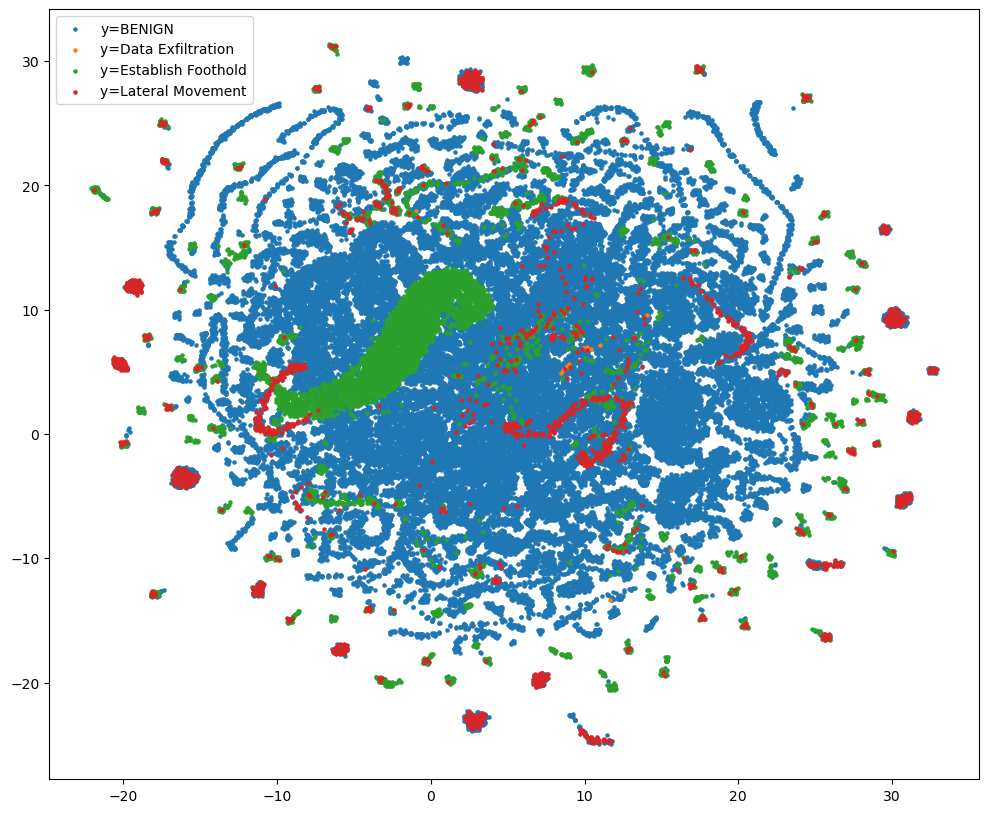

In [23]:
plot_umaps(None, clean_dapt[clean_dapt.columns[:-1]].to_numpy(), clean_dapt['Label'], n_neighbors=50, min_dist=1.0)